In [19]:
from faker import Faker
import pandas as pd
import random

# Instantiate Faker
fake = Faker()

# Define possible HTTP methods and response codes
http_methods = ['GET', 'POST', 'PUT', 'DELETE', 'PATCH']
response_codes = [200, 201, 202, 204, 400, 401, 403, 404, 500]

# Prepare empty lists to hold data
source_ips = []
user_agents = []
urls = []
methods = []
responses = []

# Generate unique IP addresses
num_unique_ips = 20  # Adjust as needed
unique_ips = [fake.ipv4() for _ in range(num_unique_ips)]

# Generate a list of unique URLs for each IP
ip_to_urls = {ip: [fake.url() for _ in range(3)] for ip in unique_ips}

# Generate data
num_records_per_ip = 7  # Adjust as needed
for ip in unique_ips:
    for _ in range(random.randint(3, 10)):  # Each IP is repeated 6-20 times
        source_ips.append(ip)
        user_agents.append(fake.user_agent())
        # Choose a URL from the pre-generated list for this IP
        urls.append(random.choice(ip_to_urls[ip]))
        methods.append(random.choice(http_methods))
        responses.append(random.choice(response_codes))

# Create a DataFrame
df = pd.DataFrame({
    'source_ip': source_ips,
    'user_agent': user_agents,
    'url': urls,
    'http_method': methods,
    'response_code': responses
})

# Save to CSV
df.to_csv('http_requests.csv', index=False)

In [20]:
import networkx as nx
import pandas as pd

df

,source_ip,user_agent,url,http_method,response_code
0,94.82.28.251,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1 like M...,https://www.walker.info/,PATCH,204
1,94.82.28.251,Mozilla/5.0 (Linux; Android 2.3) AppleWebKit/5...,http://www.stephens-simpson.info/,GET,401
2,94.82.28.251,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_8_9) A...,http://www.stephens-simpson.info/,PUT,202
3,94.82.28.251,Opera/8.41.(X11; Linux i686; ht-HT) Presto/2.9...,http://www.stephens-simpson.info/,PUT,401
4,94.82.28.251,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,http://www.stephens-simpson.info/,GET,200
...,...,...,...,...,...
106,141.233.239.160,Mozilla/5.0 (Linux; Android 8.0.0) AppleWebKit...,http://montoya-hebert.com/,POST,201
107,141.233.239.160,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,https://www.allen.net/,PATCH,204
108,141.233.239.160,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,https://www.allen.net/,PATCH,400
109,141.233.239.160,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,http://montoya-hebert.com/,PUT,403


In [24]:

# Create an empty Directed Graph
G = nx.DiGraph()

# Add nodes and edges with their attributes
for index, row in df.iterrows():
    # Add nodes
    G.add_node(row['source_ip'], node_type='ip')
    G.add_node(row['user_agent'], node_type='user_agent')
    G.add_node(row['url'], node_type='url')

    # Add edges (relationships)
    G.add_edge(row['source_ip'], row['url'], method=row['http_method'], response_code=row['response_code'])
    G.add_edge(row['url'], row['user_agent'])
    G.add_edge(row['source_ip'], row['user_agent'])

# Print the graph
print(nx.info(G))

DiGraph with 182 nodes and 274 edges


C:\Users\i00646629\AppData\Local\Temp\ipykernel_23452\575551315.py:17: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [46]:
import plotly.graph_objects as go
import networkx as nx

# Assuming you have a NetworkX graph G

pos = nx.spring_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

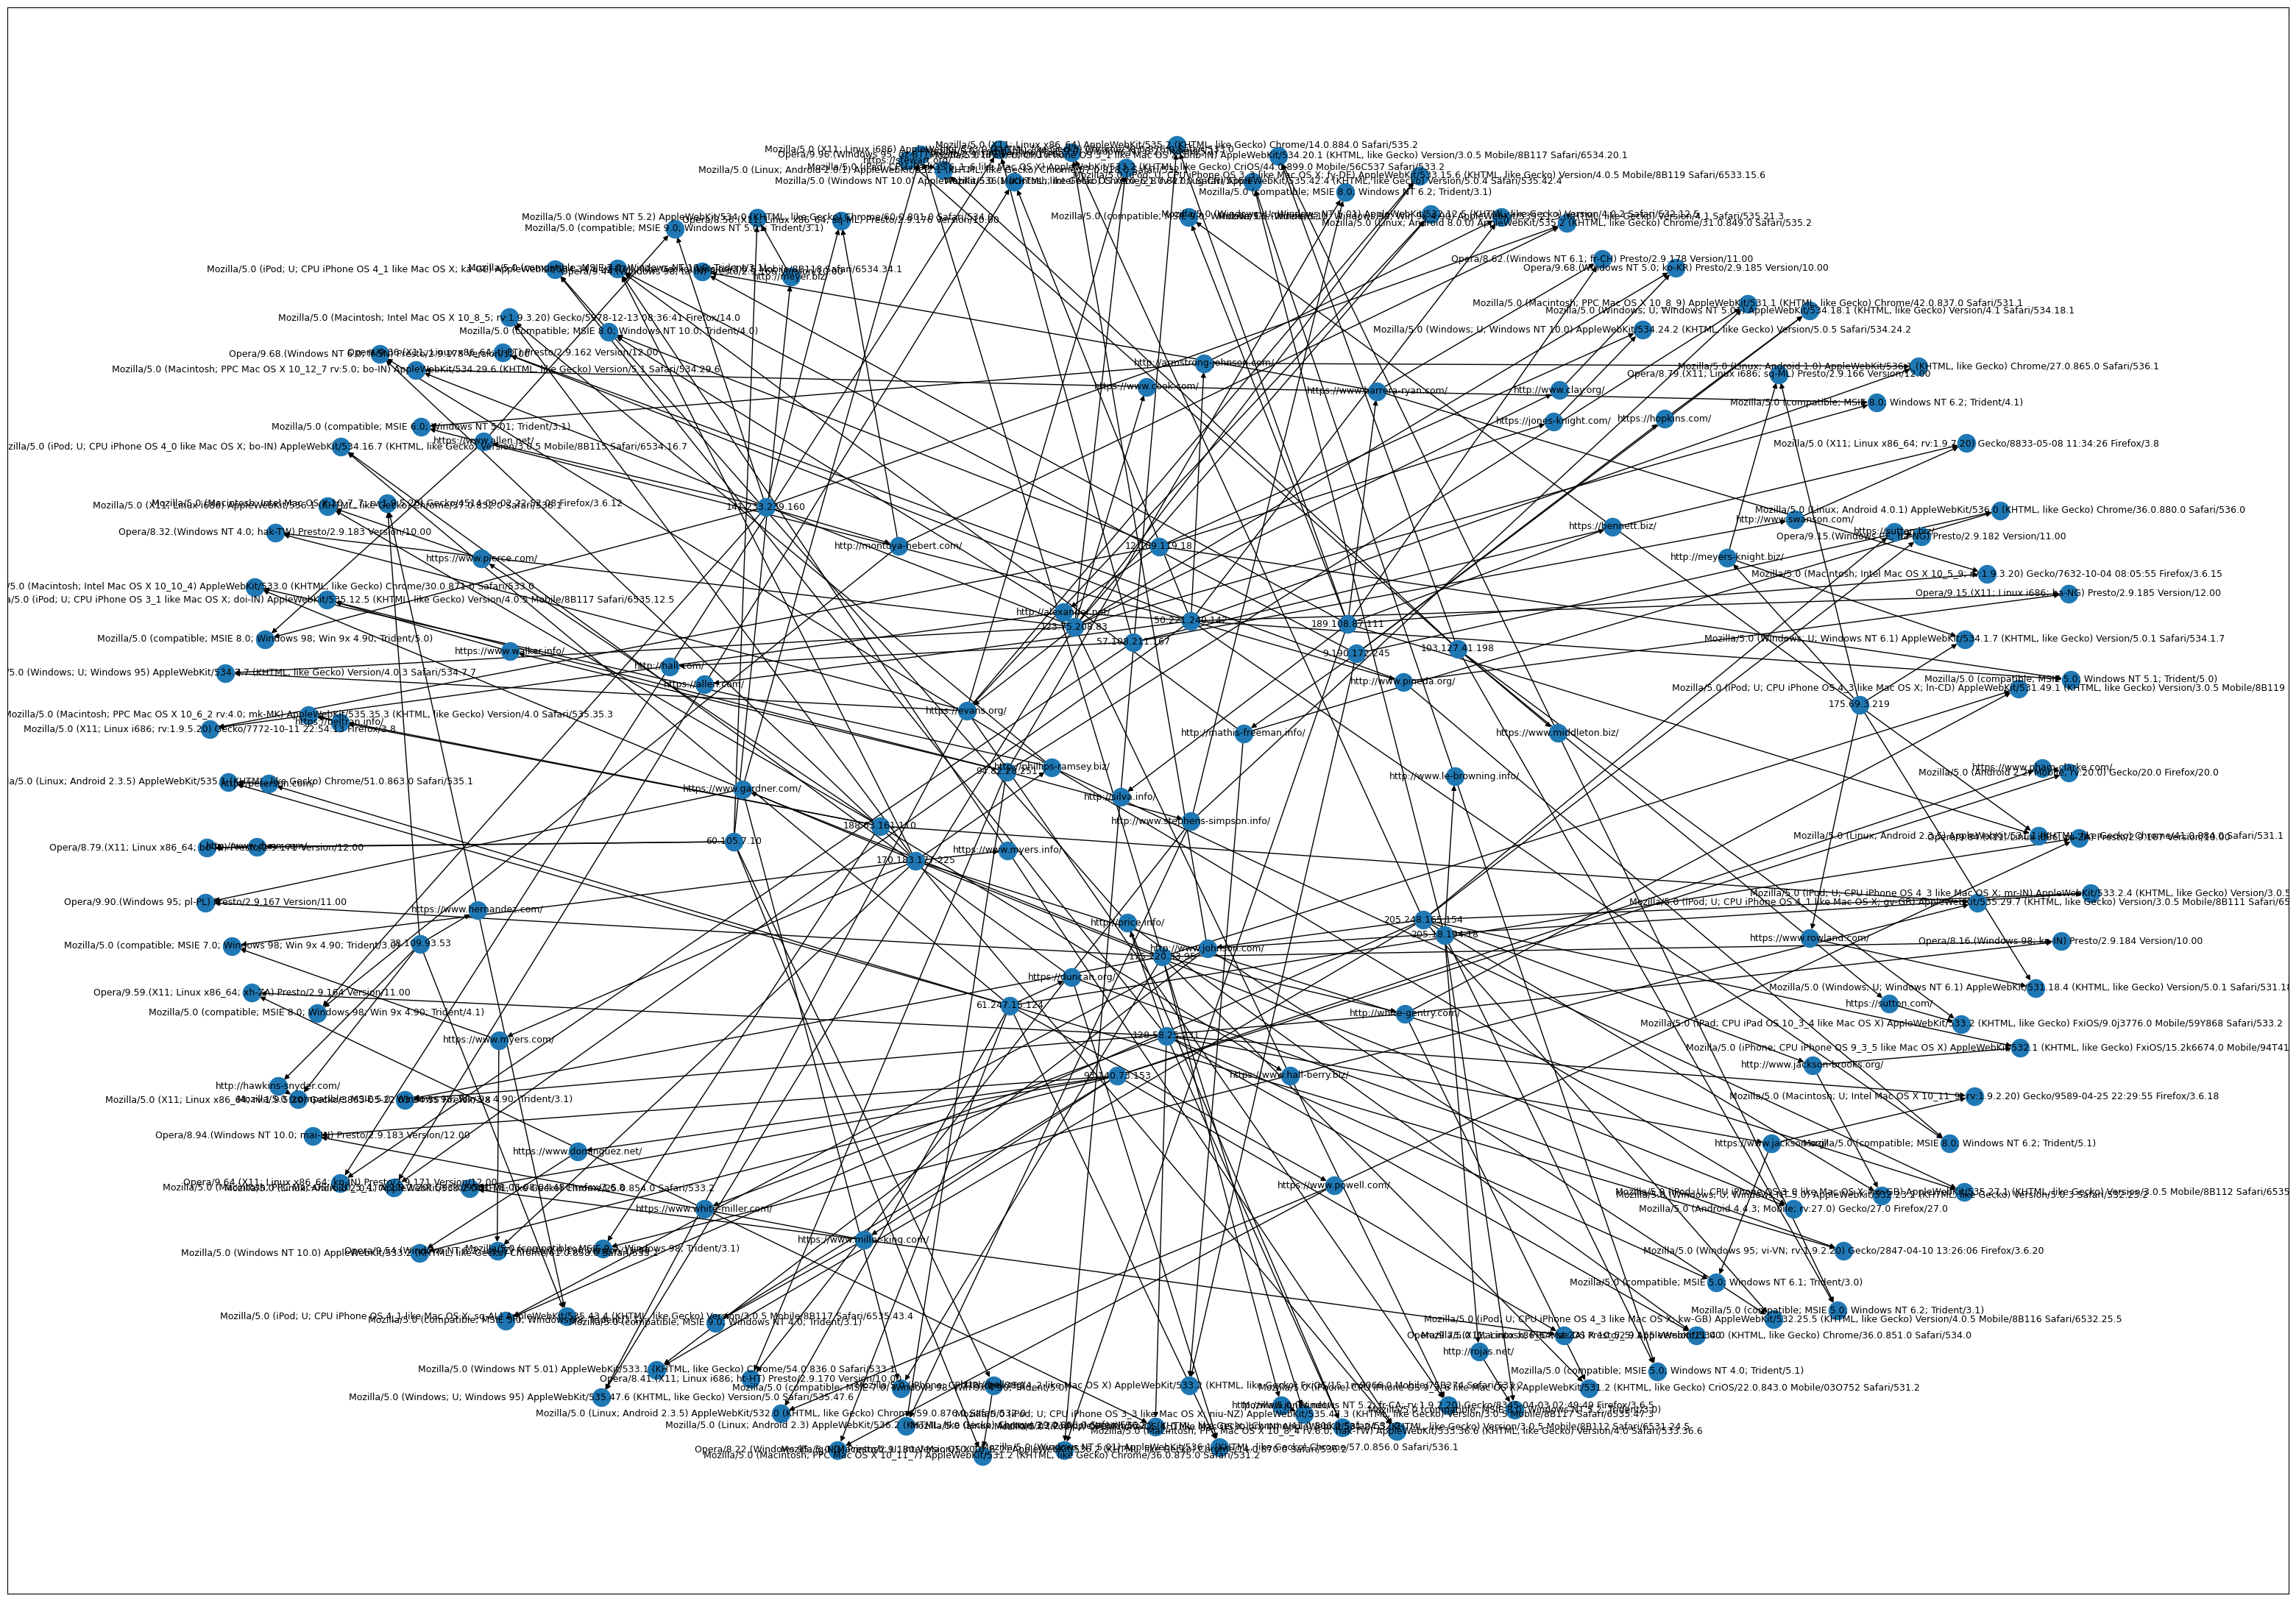

In [51]:
import matplotlib.pyplot as plt

# Larger figure size
plt.figure(figsize=(40, 28))

# Draw the graph using the spring layout
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, font_size=9)

# Show the plot
plt.show()

In [52]:
import ipaddress

# Create a node attributes dictionary
ip_attributes = {ip: ip_to_urls[ip] for ip in unique_ips}
user_agent_attributes = {user_agent: [] for user_agent in df['user_agent'].unique()}
node_attributes = {**ip_attributes, **user_agent_attributes}

def is_ip(node):
    try:
        ipaddress.ip_address(node)
        return True
    except ValueError:
        return False

In [53]:
# Generate adjacency (i.e., number of connections) for each node
node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))

# Define the node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',  # You can change the colorscale as desired
        reversescale=True,
        color=node_adjacencies,  # Use the number of connections as the color
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2),
    text=[f'IP: {node}, URL: {df[df["source_ip"] == node]["url"].iloc[0]}' if is_ip(node) and df[df["source_ip"] == node].shape[0] > 0 
          else f'URL: {node}, IP: {df[df["url"] == node]["source_ip"].iloc[0]}' if df[df["url"] == node].shape[0] > 0 else 'Data not available' for node in G.nodes()],
    textposition="top center")

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Attackers connection graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()
